In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from fashion_mnist.utils.mnist_reader import load_mnist

In [3]:
total_train_image, total_train_labels = load_mnist('./fashion_mnist/data/fashion/', kind='train')
test_image, test_labels = load_mnist('./fashion_mnist/data/fashion/', kind='t10k')

In [4]:
train_image, validation_image = train_test_split(total_train_image, test_size=0.15, random_state=0)
train_labels, validation_labels = train_test_split(total_train_labels, test_size=0.15, random_state=0)

In [5]:
train_labels_onehot = pd.get_dummies(train_labels)
validation_labels_onehot = pd.get_dummies(validation_labels)
test_labels_onehot = pd.get_dummies(test_labels)

In [6]:
def softmax(z):
    exp_num = tf.exp(z)
    sum_div = tf.reduce_sum(exp_num,1, keepdims=True)
    return exp_num / sum_div

def sigmoid(z):
    return 1 / (1 + tf.exp(-z))    

def cross_entropy(y, h):
    return tf.reduce_mean(tf.reduce_sum(-tf.log(h)*y,1, keepdims=True))

def theta_update(theta, gradient):
    return theta.assign(theta - lr * gradient)

def relu(z):
    return tf.maximum(z, 0)
    
def relu_derivative(x):
    condition = tf.greater(x, 0.)
    return tf.where(condition,tf.ones_like(x),tf.zeros_like(x))

In [7]:
lr = 0.000001
hidden = 2**8
batch = train_image.shape[0]
epochs = 1000
iterations = int(train_image.shape[0]/batch)

In [8]:
#plt.imshow(test_image[30].reshape(28,28))

In [9]:
x_ori = tf.placeholder(tf.float32, shape =([None,28*28]))
X = tf.concat([tf.ones((tf.shape(x_ori)[0],1),dtype=tf.float32),x_ori],axis=1)

y = tf.placeholder(tf.float32, shape =([None, 10]))

In [10]:
theta1 = tf.get_variable("theta1", shape=(28*28+1,hidden), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [11]:
gradient1 = tf.get_variable("gradient1", shape=(28*28+1,hidden), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [12]:
theta2 = tf.get_variable("theta2", shape=(hidden+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [13]:
gradient2 = tf.get_variable("gradient2", shape=(hidden+1,10), dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer())

In [14]:
z1 = tf.matmul(X, theta1)
h1_ori = sigmoid(z1)
h1 = tf.concat([tf.ones((tf.shape(x_ori)[0],1),dtype=tf.float32),h1_ori],axis=1)

In [15]:
z2 = tf.matmul(h1, theta2)
h2 = softmax(z2)

In [16]:
gradient2_update = gradient2.assign(tf.tensordot(tf.transpose(h1), tf.subtract(h2, y),1))

In [17]:
theta2_update = theta2.assign(theta2 - lr * gradient2)

In [18]:
dE_dz2 = h2-y

In [19]:
dE_dh1 = tf.matmul(dE_dz2 , tf.transpose(theta2[1:,:]))

In [20]:
dE_dz1 = tf.multiply(dE_dh1,tf.multiply(h1_ori,tf.subtract(tf.ones_like(h1_ori),h1_ori)))

In [21]:
gradient1_update = gradient1.assign(tf.matmul(tf.transpose(X), dE_dz1))

In [22]:
theta1_update = theta1.assign(theta1 - lr * gradient1)

In [23]:
loss = cross_entropy(y,h2)

In [24]:
tf_X = tf.placeholder(tf.float32)
tf_X_norm = tf.image.per_image_standardization(tf_X)

In [25]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

train_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: train_image})
validation_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: validation_image})
test_image_norm = sess.run(tf_X_norm, feed_dict={tf_X: test_image})

In [26]:
sess.run(tf.global_variables_initializer())

train_epoch_loss_list = []
validation_epoch_loss_list = []

for i in range(epochs):
    batch_accumulate_loss = 0
    
    print('Epoch {}'.format(i))
    for j in range(iterations):
        index = j*batch
        theta_value = sess.run([gradient2_update,theta2_update,gradient1_update, theta1_update], feed_dict={x_ori:train_image_norm[index:index+batch], y:train_labels_onehot[index:index+batch]})
        train_loss_value = sess.run(loss, feed_dict={x_ori:train_image_norm[index:index+batch], y:train_labels_onehot[index:index+batch]})
        batch_accumulate_loss += train_loss_value

    train_epoch_loss = batch_accumulate_loss/iterations
    train_epoch_loss_list.append(train_epoch_loss)
    validation_epoch_loss = sess.run(loss, feed_dict={x_ori:validation_image_norm, y:validation_labels_onehot})
    validation_epoch_loss_list.append(validation_epoch_loss)

    print('Iteration loss:')
    print(train_epoch_loss)
    #print('Validation loss:')
    #print(validation_epoch_loss)

Epoch 0
Iteration loss:
2.5811398029327393
Epoch 1
Iteration loss:
2.37532377243042
Epoch 2
Iteration loss:
2.242229700088501
Epoch 3
Iteration loss:
2.1407530307769775
Epoch 4
Iteration loss:
2.055532693862915
Epoch 5
Iteration loss:
1.9806158542633057
Epoch 6
Iteration loss:
1.9133083820343018
Epoch 7
Iteration loss:
1.852135419845581
Epoch 8
Iteration loss:
1.7961488962173462
Epoch 9
Iteration loss:
1.7446699142456055
Epoch 10
Iteration loss:
1.6971733570098877
Epoch 11
Iteration loss:
1.65323007106781
Epoch 12
Iteration loss:
1.61247718334198
Epoch 13
Iteration loss:
1.5746008157730103
Epoch 14
Iteration loss:
1.539325475692749
Epoch 15
Iteration loss:
1.5064082145690918
Epoch 16
Iteration loss:
1.4756330251693726
Epoch 17
Iteration loss:
1.446807622909546
Epoch 18
Iteration loss:
1.4197602272033691
Epoch 19
Iteration loss:
1.3943376541137695
Epoch 20
Iteration loss:
1.3704025745391846
Epoch 21
Iteration loss:
1.3478314876556396
Epoch 22
Iteration loss:
1.3265138864517212
Epoch 23


Iteration loss:
0.6859287619590759
Epoch 189
Iteration loss:
0.6850418448448181
Epoch 190
Iteration loss:
0.684161365032196
Epoch 191
Iteration loss:
0.683287501335144
Epoch 192
Iteration loss:
0.6824201941490173
Epoch 193
Iteration loss:
0.681559145450592
Epoch 194
Iteration loss:
0.6807043552398682
Epoch 195
Iteration loss:
0.6798558235168457
Epoch 196
Iteration loss:
0.6790134310722351
Epoch 197
Iteration loss:
0.6781770586967468
Epoch 198
Iteration loss:
0.6773466467857361
Epoch 199
Iteration loss:
0.6765220761299133
Epoch 200
Iteration loss:
0.6757033467292786
Epoch 201
Iteration loss:
0.6748903393745422
Epoch 202
Iteration loss:
0.6740830540657043
Epoch 203
Iteration loss:
0.6732812523841858
Epoch 204
Iteration loss:
0.6724850535392761
Epoch 205
Iteration loss:
0.6716942191123962
Epoch 206
Iteration loss:
0.6709088683128357
Epoch 207
Iteration loss:
0.6701288223266602
Epoch 208
Iteration loss:
0.6693539619445801
Epoch 209
Iteration loss:
0.6685843467712402
Epoch 210
Iteration los

Iteration loss:
0.5854652523994446
Epoch 373
Iteration loss:
0.5851179361343384
Epoch 374
Iteration loss:
0.584771990776062
Epoch 375
Iteration loss:
0.5844272971153259
Epoch 376
Iteration loss:
0.5840839147567749
Epoch 377
Iteration loss:
0.5837417840957642
Epoch 378
Iteration loss:
0.5834007859230042
Epoch 379
Iteration loss:
0.583061158657074
Epoch 380
Iteration loss:
0.5827227234840393
Epoch 381
Iteration loss:
0.5823854804039001
Epoch 382
Iteration loss:
0.5820494890213013
Epoch 383
Iteration loss:
0.5817146897315979
Epoch 384
Iteration loss:
0.58138108253479
Epoch 385
Iteration loss:
0.5810487270355225
Epoch 386
Iteration loss:
0.5807175040245056
Epoch 387
Iteration loss:
0.5803874731063843
Epoch 388
Iteration loss:
0.5800586938858032
Epoch 389
Iteration loss:
0.5797309875488281
Epoch 390
Iteration loss:
0.5794044137001038
Epoch 391
Iteration loss:
0.5790790915489197
Epoch 392
Iteration loss:
0.5787549018859863
Epoch 393
Iteration loss:
0.5784317851066589
Epoch 394
Iteration loss

Iteration loss:
0.537338376045227
Epoch 557
Iteration loss:
0.5371402502059937
Epoch 558
Iteration loss:
0.5369426608085632
Epoch 559
Iteration loss:
0.536745548248291
Epoch 560
Iteration loss:
0.5365489721298218
Epoch 561
Iteration loss:
0.536352813243866
Epoch 562
Iteration loss:
0.5361572504043579
Epoch 563
Iteration loss:
0.5359621047973633
Epoch 564
Iteration loss:
0.5357674360275269
Epoch 565
Iteration loss:
0.5355733036994934
Epoch 566
Iteration loss:
0.5353796482086182
Epoch 567
Iteration loss:
0.5351865291595459
Epoch 568
Iteration loss:
0.5349937677383423
Epoch 569
Iteration loss:
0.5348016023635864
Epoch 570
Iteration loss:
0.534609854221344
Epoch 571
Iteration loss:
0.5344185829162598
Epoch 572
Iteration loss:
0.5342277884483337
Epoch 573
Iteration loss:
0.5340374708175659
Epoch 574
Iteration loss:
0.5338476300239563
Epoch 575
Iteration loss:
0.5336582660675049
Epoch 576
Iteration loss:
0.5334693193435669
Epoch 577
Iteration loss:
0.5332808494567871
Epoch 578
Iteration loss

Iteration loss:
0.5076042413711548
Epoch 741
Iteration loss:
0.5074719190597534
Epoch 742
Iteration loss:
0.5073398351669312
Epoch 743
Iteration loss:
0.5072079300880432
Epoch 744
Iteration loss:
0.5070763826370239
Epoch 745
Iteration loss:
0.5069450736045837
Epoch 746
Iteration loss:
0.5068139433860779
Epoch 747
Iteration loss:
0.5066831111907959
Epoch 748
Iteration loss:
0.506552517414093
Epoch 749
Iteration loss:
0.5064221620559692
Epoch 750
Iteration loss:
0.5062920451164246
Epoch 751
Iteration loss:
0.506162166595459
Epoch 752
Iteration loss:
0.5060325264930725
Epoch 753
Iteration loss:
0.5059031844139099
Epoch 754
Iteration loss:
0.5057740211486816
Epoch 755
Iteration loss:
0.5056451559066772
Epoch 756
Iteration loss:
0.5055164694786072
Epoch 757
Iteration loss:
0.505388081073761
Epoch 758
Iteration loss:
0.5052598714828491
Epoch 759
Iteration loss:
0.5051319599151611
Epoch 760
Iteration loss:
0.5050042271614075
Epoch 761
Iteration loss:
0.5048767328262329
Epoch 762
Iteration los

Iteration loss:
0.4867686629295349
Epoch 925
Iteration loss:
0.48667147755622864
Epoch 926
Iteration loss:
0.4865744411945343
Epoch 927
Iteration loss:
0.4864775836467743
Epoch 928
Iteration loss:
0.48638081550598145
Epoch 929
Iteration loss:
0.4862842261791229
Epoch 930
Iteration loss:
0.48618781566619873
Epoch 931
Iteration loss:
0.4860915243625641
Epoch 932
Iteration loss:
0.485995352268219
Epoch 933
Iteration loss:
0.4858993589878082
Epoch 934
Iteration loss:
0.4858034551143646
Epoch 935
Iteration loss:
0.48570773005485535
Epoch 936
Iteration loss:
0.4856121242046356
Epoch 937
Iteration loss:
0.4855166971683502
Epoch 938
Iteration loss:
0.48542138934135437
Epoch 939
Iteration loss:
0.48532620072364807
Epoch 940
Iteration loss:
0.4852311611175537
Epoch 941
Iteration loss:
0.4851362705230713
Epoch 942
Iteration loss:
0.4850414991378784
Epoch 943
Iteration loss:
0.4849468767642975
Epoch 944
Iteration loss:
0.4848523736000061
Epoch 945
Iteration loss:
0.48475804924964905
Epoch 946
Iter

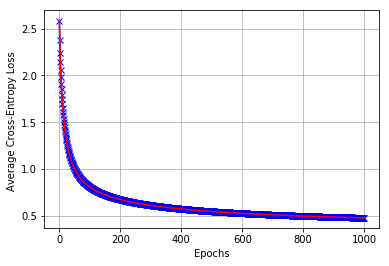

In [27]:
fig = plt.figure(1)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Average Cross-Entropy Loss ')
plt.plot(range(len(train_epoch_loss_list)),train_epoch_loss_list, '-bx')
plt.plot(range(len(validation_epoch_loss_list)),validation_epoch_loss_list, '-r')

plt.show()

In [28]:
h2_values = sess.run(h2, feed_dict={x_ori:test_image_norm})

In [29]:
result_labels = np.zeros_like(h2_values,dtype=int)

In [30]:
result_labels[np.arange(len(h2_values)), h2_values.argmax(1)] = 1

In [31]:
result_labels = np.argmax(result_labels, axis=1)

In [32]:
from sklearn.metrics import f1_score

In [33]:
f1_score(test_labels,result_labels, average='micro')

0.819

In [34]:
from pandas_ml import ConfusionMatrix

In [35]:
ConfusionMatrix(test_labels,result_labels)

Predicted     0    1    2     3     4    5    6     7    8     9  __all__
Actual                                                                   
0           806    4   12    62     4    5   92     0   15     0     1000
1             3  937   13    38     5    0    3     0    1     0     1000
2            17    0  706    10   138    2  116     0   11     0     1000
3            31   13   12   857    37    1   45     0    4     0     1000
4             1    2  108    36   745    0  103     0    5     0     1000
5             0    0    0     2     0  889    0    65    6    38     1000
6           165    4  123    46   108    6  518     0   30     0     1000
7             0    0    0     0     0   52    0   880    0    68     1000
8             1    1   13    12     2   15   23     7  924     2     1000
9             0    0    0     0     0   23    0    48    1   928     1000
__all__    1024  961  987  1063  1039  993  900  1000  997  1036    10000